In [21]:
%matplotlib inline

# general
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import time

# modelling
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.linear_model import LinearRegression,lars_path,LassoCV,RidgeCV, ElasticNetCV
from sklearn import linear_model
from sklearn import metrics
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score, max_error, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


In [22]:
data_for_modeling = pd.read_csv('data/listings_cleaned_with_counts_final.csv', index_col=['id'])
data_all = pd.read_csv('data/listings.csv', index_col=['id'])
data_all = data_all.loc[data_for_modeling.index]
len(data_all) == len(data_for_modeling)

True

In [23]:
cols = ['property_type','room_type','bed_type','cancellation_policy','neighbourhood']
cat_cols = data_all[cols]

<AxesSubplot:>

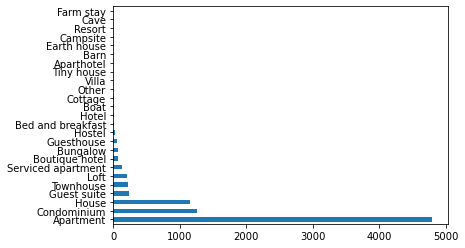

In [24]:
cat_cols['property_type'].value_counts().plot(kind='barh')

In [25]:
threshold_percent = 10
series = pd.value_counts(cat_cols['property_type'])
mask = (series / series.sum() * 100).lt(threshold_percent)
cat_cols = cat_cols.assign(property_type = np.where(cat_cols['property_type'].isin(series[mask].index),'Other', cat_cols['property_type']))
cat_cols

,property_type,room_type,bed_type,cancellation_policy,neighbourhood
id,,,,,
1947,Apartment,Entire home/apt,Real Bed,moderate,Near North Side
2384,Condominium,Private room,Real Bed,strict_14_with_grace_period,Hyde Park
4505,Apartment,Entire home/apt,Real Bed,moderate,Little Village
7126,Apartment,Entire home/apt,Futon,moderate,Ukrainian Village
9811,Apartment,Entire home/apt,Real Bed,moderate,Old Town
...,...,...,...,...,...
43239736,Apartment,Entire home/apt,Real Bed,flexible,Hyde Park
43249502,Other,Entire home/apt,Real Bed,strict_14_with_grace_period,West Town/Noble Square
43250054,Other,Private room,Real Bed,flexible,Uptown


<AxesSubplot:>

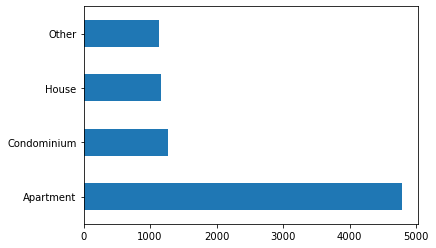

In [26]:
cat_cols['property_type'].value_counts().plot(kind='barh')

In [27]:
threshold_percent = 10

series = pd.value_counts(cat_cols['bed_type'])
mask = (series / series.sum() * 100).lt(threshold_percent)
cat_cols = cat_cols.assign(bed_type = np.where(cat_cols['bed_type'].isin(series[mask].index),'Other', cat_cols['bed_type']))
cat_cols

,property_type,room_type,bed_type,cancellation_policy,neighbourhood
id,,,,,
1947,Apartment,Entire home/apt,Real Bed,moderate,Near North Side
2384,Condominium,Private room,Real Bed,strict_14_with_grace_period,Hyde Park
4505,Apartment,Entire home/apt,Real Bed,moderate,Little Village
7126,Apartment,Entire home/apt,Other,moderate,Ukrainian Village
9811,Apartment,Entire home/apt,Real Bed,moderate,Old Town
...,...,...,...,...,...
43239736,Apartment,Entire home/apt,Real Bed,flexible,Hyde Park
43249502,Other,Entire home/apt,Real Bed,strict_14_with_grace_period,West Town/Noble Square
43250054,Other,Private room,Real Bed,flexible,Uptown


In [28]:
data_for_modeling = pd.concat([data_for_modeling, cat_cols], axis=1)

In [29]:
data_for_modeling.head()

,host_listings_count,latitude,longitude,accommodates,bathrooms,price,security_deposit,cleaning_fee,extra_people,minimum_nights,...,bars,cafes,universities,cta,time_to_cta_minutes,property_type,room_type,bed_type,cancellation_policy,neighbourhood
id,,,,,,,,,,,,,,,,,,,,,
1947,4,41.90246,-87.63405,2,1.0,59.0,100.0,0.0,0.0,14,...,50.0,56.0,2.0,3.0,4.66,Apartment,Entire home/apt,Real Bed,moderate,Near North Side
2384,1,41.78790,-87.58780,1,1.0,55.0,0.0,20.0,0.0,2,...,3.0,10.0,3.0,0.0,27.36,Condominium,Private room,Real Bed,strict_14_with_grace_period,Hyde Park
4505,1,41.85495,-87.69696,7,1.0,117.0,0.0,30.0,20.0,2,...,2.0,1.0,0.0,2.0,8.86,Apartment,Entire home/apt,Real Bed,moderate,Little Village
7126,2,41.90289,-87.68182,2,1.0,80.0,0.0,0.0,0.0,2,...,44.0,33.0,0.0,1.0,14.01,Apartment,Entire home/apt,Other,moderate,Ukrainian Village
9811,10,41.91769,-87.63788,4,1.0,150.0,0.0,85.0,25.0,4,...,40.0,20.0,1.0,2.0,11.24,Apartment,Entire home/apt,Real Bed,moderate,Old Town


In [30]:
data_for_modeling = pd.get_dummies(data_for_modeling)
data_for_modeling.columns = data_for_modeling.columns.str.replace(' ','_')
data_for_modeling.head()

,host_listings_count,latitude,longitude,accommodates,bathrooms,price,security_deposit,cleaning_fee,extra_people,minimum_nights,...,neighbourhood_Washington_Park,neighbourhood_West_Elsdon,neighbourhood_West_Lawn,neighbourhood_West_Loop/Greektown,neighbourhood_West_Pullman,neighbourhood_West_Ridge,neighbourhood_West_Town/Noble_Square,neighbourhood_Wicker_Park,neighbourhood_Woodlawn,neighbourhood_Wrigleyville
id,,,,,,,,,,,,,,,,,,,,,
1947,4,41.90246,-87.63405,2,1.0,59.0,100.0,0.0,0.0,14,...,0,0,0,0,0,0,0,0,0,0
2384,1,41.78790,-87.58780,1,1.0,55.0,0.0,20.0,0.0,2,...,0,0,0,0,0,0,0,0,0,0
4505,1,41.85495,-87.69696,7,1.0,117.0,0.0,30.0,20.0,2,...,0,0,0,0,0,0,0,0,0,0
7126,2,41.90289,-87.68182,2,1.0,80.0,0.0,0.0,0.0,2,...,0,0,0,0,0,0,0,0,0,0
9811,10,41.91769,-87.63788,4,1.0,150.0,0.0,85.0,25.0,4,...,0,0,0,0,0,0,0,0,0,0


In [31]:
data_for_modeling = data_for_modeling.dropna()
data_for_modeling.isnull().sum()

host_listings_count                     0
latitude                                0
longitude                               0
accommodates                            0
bathrooms                               0
                                       ..
neighbourhood_West_Ridge                0
neighbourhood_West_Town/Noble_Square    0
neighbourhood_Wicker_Park               0
neighbourhood_Woodlawn                  0
neighbourhood_Wrigleyville              0
Length: 128, dtype: int64

In [32]:
cols_to_drop = ['host_listings_count','latitude','longitude','maximum_minimum_nights','minimum_maximum_nights','availability_365']
data_for_modeling = data_for_modeling.drop(columns=cols_to_drop)

In [33]:
X = data_for_modeling.drop('price', axis=1)
y = data_for_modeling.price

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y, test_size=0.25,random_state=123)

### Linear Regression


Training RMSE: 87.8599
Validation RMSE: 88.2064

Training r2: 0.4506
Validation r2: 0.4213




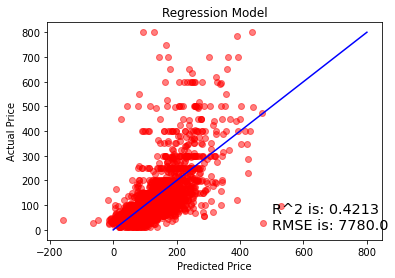

In [40]:
steps_lingreg = [#('scaler', StandardScaler()),
         ('linreg', LinearRegression())]

pipeline_linreg = Pipeline(steps=steps_lingreg)
pipeline_linreg.fit(X_train, y_train)

y_train_pred = pipeline_linreg.predict(X_train)
y_test_pred = pipeline_linreg.predict(X_test)

print("\nTraining RMSE:", round(mean_squared_error(y_train, y_train_pred,squared=False),4))
print("Validation RMSE:", round(mean_squared_error(y_test, y_test_pred,squared=False),4))

print("\nTraining r2:", round(r2_score(y_train, y_train_pred),4))
print("Validation r2:", round(r2_score(y_test, y_test_pred),4))
print('\n')
y_test_array = np.array(y_test)
y_test_pred_array = np.array(y_test_pred)
new_df = pd.DataFrame({'Actual': y_test_array.flatten(), 'Predicted': y_test_pred_array.flatten()})

plt.plot([0,800],[0,800],color='b')
plt.scatter(y_test_pred, y_test, alpha=.5,
            color='r') #alpha helps to show overlapping data

#plt.grid(True)
overlay = 'R^2 is: {}\nRMSE is: {}'.format(
                    (round(r2_score(y_test, y_test_pred),4)),
                    (round(mean_squared_error(y_test, y_test_pred))),4)
plt.annotate(s=overlay,xy=(500,2.5),size='x-large')
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Regression Model')

plt.show()

### Polynomial Linear Regression

In [41]:
steps_poly = [#('scaler', StandardScaler()), 
('poly_features', PolynomialFeatures(2, interaction_only=False)), ('linreg', LinearRegression())]

pipeline_poly = Pipeline(steps=steps_poly)
pipeline_poly.fit(X_train, y_train)

y_train_pred_poly = pipeline_poly.predict(X_train)
y_test_pred_poly = pipeline_poly.predict(X_test)

print("\nTraining RMSE:", round(mean_squared_error(y_train, y_train_pred_poly,squared=False),4))
print("Validation RMSE:", round(mean_squared_error(y_test, y_test_pred_poly,squared=False),4))

print("\nTraining r2:", round(r2_score(y_train, y_train_pred_poly),4))
print("Validation r2:", round(r2_score(y_test, y_test_pred_poly),4))


Training RMSE: 66.0384
Validation RMSE: 1192237.3452

Training r2: 0.6896
Validation r2: -105731507.6471


### Elastic Net Regressor

In [37]:
steps_elastic = [('scaler', StandardScaler()), ('poly_features', PolynomialFeatures(2, interaction_only=False)), ('elastic', ElasticNetCV())]

pipeline_net = Pipeline(steps=steps_elastic)

parameters = dict(elastic__l1_ratio=[0.5,1],
elastic__alphas = [np.linspace(0,3,10)])

clf = GridSearchCV(pipeline_net, parameters,scoring='r2')

# Fit the grid search
clf.fit(X_train, y_train)

y_train_pred_net = clf.predict(X_train)
y_test_pred_net = clf.predict(X_test)

print("\nTraining RMSE:", round(mean_squared_error(y_train, y_train_pred_net,squared=False),4))
print("Validation RMSE:", round(mean_squared_error(y_test, y_test_pred_net,squared=False),4))

print("\nTraining r2:", round(r2_score(y_train, y_train_pred_net),4))
print("Validation r2:", round(r2_score(y_test, y_test_pred_net),4))

plt.figure(figsize=(12,8))
plt.scatter(y_test, y_test_pred_net)
plt.plot([0,800],[0,800],color='blue')
plt.grid(True)
plt.title('Predicted vs. Actual Rental Price with LASSO CV')
plt.ylabel('Rental Price Predicted')
plt.xlabel('Rental Price Actual')

# View The Best Parameters
#print('Best Number Of Components:', clf.best_estimator_.get_params())

# # Use Cross Validation To Evaluate Model
# CV_Result = cross_val_score(clf, X, y, cv=5, n_jobs=-1, scoring='r2')
# print(); print(CV_Result)
# print(); print(CV_Result.mean())
# print(); print(CV_Result.std())

KeyboardInterrupt: 

In [21]:
print(clf.best_score_)
print(clf.best_params_)

0.4806656770195777
{'elastic__alphas': array([0.        , 0.33333333, 0.66666667, 1.        , 1.33333333,
       1.66666667, 2.        , 2.33333333, 2.66666667, 3.        ]), 'elastic__l1_ratio': 1}


### XGBoost

In [51]:
xgb_reg_start = time.time()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y.values.reshape(-1,1))

X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled,y_scaled, test_size = 0.2,random_state = 123)

# poly = PolynomialFeatures(degree=2).fit(X_train_scaled)
# X_train_poly = poly.transform(X_train_scaled) 
# X_test_poly = poly.transform(X_test_scaled) 
# print("X_train.shape: {}".format(X_train_scaled.shape)) 
# print("X_train_poly.shape: {}".format(X_train_poly.shape))

# X_train_poly.sort_index(axis=1, inplace=True)
# X_train_poly.sort_index(axis=1,inplace=True)

xgb_reg = xgb.XGBRegressor(objective ='reg:squarederror', booster='gbtree', max_depth=7, learning_rate = 0.1,min_child_weight = 1,subsample = 0.3,n_jobs = 3,n_estimators = 200,colsample_bytree = 0.6,alpha = 0.5)


# alphas = float(np.linspace(0,2,10))
parameters = dict(max_depth=[15],
learning_rate = [0.1],
min_child_weight = [1],
subsample = [0.2],
n_jobs = [3],
n_estimators = [200],
colsample_bytree = [0.6],
alpha = [0.01])

# xgb_clf = RandomizedSearchCV(xgb_reg, parameters, scoring='r2')

# xgb_clf.fit(X_train_poly,y_train_scaled,early_stopping_rounds=10,eval_set=[(X_test_poly, y_test_scaled)])

xgb_reg.fit(X_train_scaled,y_train_scaled,early_stopping_rounds=10,eval_set=[(X_test_scaled, y_test_scaled)])

training_preds_xgb_reg = xgb_reg.predict(X_train_scaled)
val_preds_xgb_reg = xgb_reg.predict(X_test_scaled)

#results = cross_val_score(xgb_reg, X_scaled, y_scaled, cv=5,scoring='r2')
#print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

#print(f"Time taken to run: {round((xgb_reg_end - xgb_reg_start)/60,1)} minutes")
print("\nTraining RMSE:", round(mean_squared_error(y_train_scaled, training_preds_xgb_reg,squared=False),4))
print("Validation RMSE:", round(mean_squared_error(y_test_scaled, val_preds_xgb_reg,squared=False),4))

print("\nTraining r2:", round(r2_score(y_train_scaled, training_preds_xgb_reg),4))
print("Validation r2:", round(r2_score(y_test_scaled, val_preds_xgb_reg),4))

xgb_reg_end = time.time()

print(f"Time taken to run: {round((xgb_reg_end - xgb_reg_start)/60,1)} minutes")

[0]	validation_0-rmse:1.05205
Will train until validation_0-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:0.99797
[2]	validation_0-rmse:0.95340
[3]	validation_0-rmse:0.91505
[4]	validation_0-rmse:0.87720
[5]	validation_0-rmse:0.84154
[6]	validation_0-rmse:0.81425
[7]	validation_0-rmse:0.79402
[8]	validation_0-rmse:0.77182
[9]	validation_0-rmse:0.75502
[10]	validation_0-rmse:0.74096
[11]	validation_0-rmse:0.72705
[12]	validation_0-rmse:0.71562
[13]	validation_0-rmse:0.70506
[14]	validation_0-rmse:0.69627
[15]	validation_0-rmse:0.68767
[16]	validation_0-rmse:0.68033
[17]	validation_0-rmse:0.67675
[18]	validation_0-rmse:0.67147
[19]	validation_0-rmse:0.66641
[20]	validation_0-rmse:0.66184
[21]	validation_0-rmse:0.65819
[22]	validation_0-rmse:0.65587
[23]	validation_0-rmse:0.65250
[24]	validation_0-rmse:0.65014
[25]	validation_0-rmse:0.64863
[26]	validation_0-rmse:0.64633
[27]	validation_0-rmse:0.64319
[28]	validation_0-rmse:0.64101
[29]	validation_0-rmse:0.63740
[30]	validation

In [26]:
xgb_clf.best_params_

{'subsample': 0.3,
 'n_jobs': 3,
 'n_estimators': 50,
 'min_child_weight': 0,
 'max_depth': 15,
 'learning_rate': 0.1,
 'colsample_bytree': 0.6,
 'alpha': 0.01}

In [403]:
steps_xgb = [('scaler', StandardScaler()),  
            ('poly_features', PolynomialFeatures(2, interaction_only=False)),
            ('xgbrg', xgb.XGBRegressor(objective ='reg:squarederror',booster='gbtree'))]

pipeline_xgb = Pipeline(steps=steps_xgb)

parameters = dict(xgbrg__max_depth=[3,5,7],
xgbrg__learning_rate = [0.01,0.1,0.15],
xgbrg__min_child_weight = [0,1,2],
xgbrg__subsample = [0.5,0.7,1],
xgbrg__colsample_bytree = [0.6,0.7,0.8],
xgbrg__alpha = [0.010])

#xgb_clf = GridSearchCV(pipeline_xgb, parameters, scoring='r2')

fit_params = {"xgbrg__eval_set": [(X_test.sort_index(axis=1,inplace=True).values, y_test.sort_index(axis=1,inplace=True).values)], 
              "xgbrg__early_stopping_rounds": [5,10], 
              "xgbrg__verbose": True} 


pipeline_xgb.fit(X_train.sort_index(axis=1,inplace=True).values,y_train.sort_index(axis=1,inplace=True).values, **fit_params)

# Fit the grid search
#xgb_clf.fit(np.array(X_train.values), y_train, **fit_params)

y_train_pred_xgb = xgb_clf.predict(X_train)
y_test_pred_xgb = xgb_clf.predict(X_test)

print("\nTraining RMSE:", round(mean_squared_error(y_train, y_train_pred_xgb,squared=False),4))
print("Validation RMSE:", round(mean_squared_error(y_test, y_test_pred_xgb,squared=False),4))

print("\nTraining r2:", round(r2_score(y_train, y_train_pred_xgb),4))
print("Validation r2:", round(r2_score(y_test, y_test_pred_xgb),4))

plt.figure(figsize=(12,8))
plt.scatter(y_test, y_test_pred_xgb)
plt.plot([-2,5],[-2,5],color='blue')
plt.grid(True)
plt.title('Predicted vs. Actual Rental Price with LASSO CV')
plt.ylabel('Rental Price Predicted')
plt.xlabel('Rental Price Actual')


AttributeError: 'NoneType' object has no attribute 'values'

In [ ]:
def poly_lassocv(dataset,target,z):
  scaler = StandardScaler()
  dataset_scaled = scaler.fit_transform(dataset)
  target_transformed = scaler.fit_transform(target.values.reshape(-1,1))

  X_train, X_test, y_train, y_test = train_test_split(dataset_scaled,target_transformed, test_size = 0.25)
  #alphas = 10**np.linspace(-2,3,200)
  poly = PolynomialFeatures(degree=z).fit(X_train)
  X_train_poly = poly.transform(X_train) 
  X_test_poly = poly.transform(X_test) 
  print("X_train.shape: {}".format(X_train.shape)) 
  print("X_train_poly.shape: {}".format(X_train_poly.shape))
  #print("Polynomial feature names:\n{}".format(poly.get_feature_names()))
  # model = LinearRegression()
  # model.fit(X_train_poly, y_train)
  # print("Linear Regression Test score : {:.4f}".format(model.score(X_test_poly,y_test)))
#   alphas = 10**np.linspace(-2,2,1000)
#   lasso = LassoCV(alphas=alphas,cv=10,tol=0.1).fit(X_train_poly, y_train.ravel()) 
  # print("Test score for degree ", z, ":", lasso.score(X_test_poly,y_test))
  #print("Test score for degree {:}: {:.3f}".format(z, lasso.score(X_test_poly,y_test)))
  xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 0.010, booster='gbtree')
  xg_reg.fit(X_train_poly,y_train)
  training_preds_xgb_reg = xgb_reg.predict(X_train_poly)
  val_preds_xgb_reg = xgb_reg.predict(X_test_poly)

  xgb_reg_end = time.time()

  print(f"Time taken to run: {round((xgb_reg_end - xgb_reg_start)/60,1)} minutes")
  print("\nTraining RMSE:", round(mean_squared_error(y_train, training_preds_xgb_reg,squared=False),4))
  print("Validation RMSE:", round(mean_squared_error(y_test, val_preds_xgb_reg,squared=False),4))

  print("\nTraining r2:", round(r2_score(y_train, training_preds_xgb_reg),4))
  print("Validation r2:", round(r2_score(y_test, val_preds_xgb_reg),4))

  print("\nTraining Max Error:", round(max_error(y_train, training_preds_xgb_reg),4))
  print("Validation Max Error:", round(max_error(y_test, val_preds_xgb_reg),4))

  print("\nTraining MAE:", round(mean_absolute_error(y_train, training_preds_xgb_reg),4))
  print("Validation MAE:", round(mean_absolute_error(y_test, val_preds_xgb_reg),4))


In [ ]:
from sklearn.model_selection import GridSearchCV

#param_grid = {'max_depth': [3,5], 'learning_rate':[0.01,0.1,0.15],'min_child_weight' : [0,1], 'n_estimators': [100],'booster':['gbtree'],'objective':["reg:squarederror"],'subsample' : [0.8,0.9,1],'colsample_bytree' : [0.6,0.7,0.8],'alpha' : [0.010]}

param_grid = {"xgbrg__n_estimators": [10, 50, 100, 500], "xgbrg__learning_rate": [0.1, 0.5, 1]}


fit_params = {"xgbrg__eval_set": [(X_test, y_test)], 
              "xgbrg__early_stopping_rounds": [5,10], 
              "xgbrg__verbose": True} 

searchCV = GridSearchCV(pipeline1, cv=5, param_grid=param_grid)
searchCV.fit(X_train, y_train,**fit_params) 
predictions_train = searchCV.predict(X_train)
predictions_test = searchCV.predict(X_test)
print("\nTraining RMSE:", round(mean_squared_error(y_train, predictions_train,squared=False),4))
print("Validation RMSE:", round(mean_squared_error(y_test, predictions_test,squared=False),4))

print("\nTraining r2:", round(r2_score(y_train, predictions_train),4))
print("Validation r2:", round(r2_score(y_test, predictions_test),4))


In [ ]:
xgb_reg_start = time.time()

xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train, y_train)
training_preds_xgb_reg = xgb_reg.predict(X_train)
val_preds_xgb_reg = xgb_reg.predict(X_test)

xgb_reg_end = time.time()

print(f"Time taken to run: {round((xgb_reg_end - xgb_reg_start)/60,1)} minutes")
print("\nTraining RMSE:", round(mean_squared_error(y_train, training_preds_xgb_reg,squared=False),4))
print("Validation RMSE:", round(mean_squared_error(y_test, val_preds_xgb_reg,squared=False),4))

print("\nTraining r2:", round(r2_score(y_train, training_preds_xgb_reg),4))
print("Validation r2:", round(r2_score(y_test, val_preds_xgb_reg),4))

print("\nTraining Max Error:", round(max_error(y_train, training_preds_xgb_reg),4))
print("Validation Max Error:", round(max_error(y_test, val_preds_xgb_reg),4))

print("\nTraining MAE:", round(mean_absolute_error(y_train, training_preds_xgb_reg),4))
print("Validation MAE:", round(mean_absolute_error(y_test, val_preds_xgb_reg),4))

In [ ]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 0.010, booster='gbtree')

In [ ]:
from sklearn.model_selection import cross_val_score
xg_reg.fit(X_train,y_train,early_stopping_rounds=10,eval_set=[(X_test, y_test)])
XGB_accuracies = cross_val_score(estimator = xg_reg, X = X_train, y = y_train, cv = 12)
print("Mean_XGB_Acc : ", XGB_accuracies.mean())

In [ ]:
xg_reg_start = time.time()
xg_reg.fit(X_train,y_train)
training_preds_xg_reg = xg_reg.predict(X_train)
val_preds_xg_reg = xg_reg.predict(X_test)

xg_reg_end = time.time()

print(f"Time taken to run: {round((xg_reg_end - xg_reg_start)/60,1)} minutes")
print("\nTraining RMSE:", round(mean_squared_error(y_train, training_preds_xg_reg,squared=False),4))
print("Validation RMSE:", round(mean_squared_error(y_test, val_preds_xg_reg,squared=False),4))

print("\nTraining r2:", round(r2_score(y_train, training_preds_xg_reg),4))
print("Validation r2:", round(r2_score(y_test, val_preds_xg_reg),4))

print("\nTraining Max Error:", round(max_error(y_train, training_preds_xg_reg),4))
print("Validation Max Error:", round(max_error(y_test, val_preds_xg_reg),4))

print("\nTraining MAE:", round(mean_absolute_error(y_train, training_preds_xg_reg),4))
print("Validation MAE:", round(mean_absolute_error(y_test, val_preds_xg_reg),4))

In [ ]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [ ]:
# params = {
#     # Parameters that we are going to tune.
#     'max_depth':6,
#     'min_child_weight': 1,
#     'eta':.3,
#     'subsample': 1,
#     'colsample_bytree': 1,
#     # Other parameters
#     'objective':"reg:squarederror",  
# }

In [ ]:
# params['eval_metric'] = "rmse"

In [ ]:
model = xgb.XGBRegressor()

In [ ]:
model.fit(X_train,y_train,eval_set=[(X_test, y_test)], early_stopping_rounds=10)

In [ ]:
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)
print("\nTraining MSE:", round(mean_squared_error(y_train, train_pred),4))
print("Validation MSE:", round(mean_squared_error(y_test, test_pred),4))
print("\nTraining r2:", round(r2_score(y_train, train_pred),4))
print("Validation r2:", round(r2_score(y_test, test_pred),4))

In [ ]:
parameters = {
    'max_depth': [3,5],
    'learning_rate':[0.01,0.1,0.15],
    'min_child_weight' : [0,1],
    'n_estimators': [100],
    'booster':['gbtree'],
    'objective':["reg:squarederror"],
    'subsample' : [0.8,0.9,1],
    'colsample_bytree' : [0.6,0.7,0.8],
    'alpha' : [0.010]

}

In [ ]:
xgb_grid = RandomizedSearchCV(model,
                        parameters,
                        cv = ,
                        n_jobs = 1,
                        verbose=False,
                        scoring='r2')

xgb_grid.fit(X_train,y_train,eval_set=[(X_test, y_test)], early_stopping_rounds=2)

In [ ]:
print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

train_pred = xgb_grid.predict(X_train)
test_pred = xgb_grid.predict(X_test)
print("\nTraining MSE:", round(mean_squared_error(y_train, train_pred),4))
print("Validation MSE:", round(mean_squared_error(y_test, test_pred),4))
print("\nTraining r2:", round(r2_score(y_train, train_pred),4))
print("Validation r2:", round(r2_score(y_test, test_pred),4))

In [ ]:
parameters_temp = {'subsample': [0.9], 'objective': ['reg:squarederror'], 'n_estimators': [100], 'min_child_weight': [1], 'max_depth': [5], 'learning_rate': [0.1], 'colsample_bytree': [0.8], 'booster': 'gbtree', 'alpha': [0.01]}

In [ ]:
parameters_temp = {
    'max_depth': [5],
    'learning_rate':[0.1],
    'min_child_weight' : [0,1],
    'n_estimators': [100],
    'booster':['gbtree'],
    'objective':["reg:squarederror"],
    'subsample' : [0.9],
    'colsample_bytree' : [0.8],
    'alpha' : [0.010]

}

In [ ]:
xgb_grid_new2 = RandomizedSearchCV(model,
                        parameters_temp,
                        cv = 4,
                        n_jobs = 1,
                        scoring='r2',
                        verbose=False)
xgb_grid_new2.fit(X_train,y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=5)

In [ ]:
print(xgb_grid_new2.best_score_)
print(xgb_grid_new2.best_params_)

train_new2_pred = xgb_grid_new2.predict(X_train)
test_new2_pred = xgb_grid_new2.predict(X_test)
print("\nTraining MSE:", round(mean_squared_error(y_train, train_new2_pred),4))
print("Validation MSE:", round(mean_squared_error(y_test, test_new2_pred),4))
print("\nTraining r2:", round(r2_score(y_train, train_new2_pred),4))
print("Validation r2:", round(r2_score(y_test, test_new2_pred),4))

In [ ]:
# from sklearn.model_selection import KFold
# from sklearn.model_selection import cross_val_score

# model = xgb.XGBRegressor()
# kfold = KFold(n_splits=15, random_state=3)
# results = cross_val_score(model, X, y, cv=kfold,scoring='r2')

In [ ]:
# print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

In [ ]:
parameters_new = {
    'max_depth': [5,6,7],
    'learning_rate':[0.1,0.01,0.2],
    'min_child_weight' : [1,2,3],
    'n_estimators': [100],
    'booster':['gbtree'],
    'min_child_weight': [0,1,2],
    'objective':["reg:squarederror"],
    'subsample' : [0.8,0.9],
    'colsample_bytree' : [0.5,0.6],
    'alpha' : [0.010,0.1]

}

In [ ]:
xgb_grid_new = RandomizedSearchCV(model,
                        parameters_new,
                        cv = 1,
                        n_jobs = 1,
                        scoring='r2',
                        verbose=False)
# results = cross_val_score(model, X, y, cv=kfold,scoring='r2')
xgb_grid_new.fit(X_train,y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=2)

In [ ]:
results

In [ ]:
print(xgb_grid_new.best_score_)
print(xgb_grid_new.best_params_)

train_pred = xgb_grid_new.predict(X_train)
test_pred = xgb_grid_new.predict(X_test)
print("\nTraining MSE:", round(mean_squared_error(y_train, train_pred),4))
print("Validation MSE:", round(mean_squared_error(y_test, test_pred),4))
print("\nTraining r2:", round(r2_score(y_train, train_pred),4))
print("Validation r2:", round(r2_score(y_test, test_pred),4))

In [ ]:
# cv_results = xgb.cv(
#     params,
#     dtrain,
#     num_boost_round=999,
#     seed=42,
#     nfold=12,
#     metrics='rmse',
#     early_stopping_rounds=10
# )
# cv_results

In [ ]:
# gridsearch_params = [
#     (max_depth, min_child_weight)
#     for max_depth in range(2,6)
#     for min_child_weight in range(1,3)
# ]

In [ ]:
# # Define initial best params and MAE
# min_rmse = float("Inf")
# best_params = None
# for max_depth, min_child_weight in gridsearch_params:
#     print("CV with max_depth={}, min_child_weight={}".format(
#                              max_depth,
#                              min_child_weight))
#     # Update our parameters
#     params['max_depth'] = max_depth
#     params['min_child_weight'] = min_child_weight
#     # Run CV
#     cv_results = xgb.cv(
#         params,
#         dtrain,
#         num_boost_round=999,
#         seed=42,
#         nfold=12,
#         metrics={'rmse'},
#         early_stopping_rounds=10
#     )
#     # Update best MAE
#     mean_rmse = cv_results['test-rmse-mean'].min()
#     boost_rounds = cv_results['test-rmse-mean'].argmin()
#     print("\tRMSE {} for {} rounds".format(mean_rmse, boost_rounds))
#     if mean_rmse < min_rmse:
#         min_rmse = mean_rmse
#         best_params = (max_depth,min_child_weight)
# print("Best params: {}, {}, RMSE: {}".format(best_params[0], best_params[1], min_rmse))

In [ ]:
# params['max_depth'] = 5
# params['min_child_weight'] = 2

In [ ]:
# gridsearch_params = [
#     (subsample, colsample)
#     for subsample in np.linspace(0.9,1,10)
#     for colsample in np.linspace(0.6,0.9,10)
# ]

In [ ]:
# min_mae = float("Inf")
# best_params = None
# # We start by the largest values and go down to the smallest
# for subsample, colsample in gridsearch_params:
#     print("CV with subsample={}, colsample={}".format(
#                              subsample,
#                              colsample))
#     # We update our parameters
#     params['subsample'] = subsample
#     params['colsample_bytree'] = colsample
#     # Run CV
#     cv_results = xgb.cv(
#         params,
#         dtrain,
#         num_boost_round=999,
#         seed=42,
#         nfold=12,
#         metrics={'rmse'},
#         early_stopping_rounds=10
#     )
#     # Update best score
#     mean_rmse = cv_results['test-rmse-mean'].min()
#     boost_rounds = cv_results['test-rmse-mean'].argmin()
#     print("\tRMSE {} for {} rounds".format(mean_rmse, boost_rounds))
#     if mean_rmse < min_rmse:
#         min_rmse = mean_rmse
#         best_params = (subsample,colsample)
# print("Best params: {}, {}, RMSE: {}".format(best_params[0], best_params[1], min_rmse))

In [ ]:
# params['subsample'] = 0.975
# params['colsample_bytree'] = 0.675

In [ ]:
# params

In [ ]:
# %time
# # This can take some time…
# min_rmse = float("Inf")
# best_params = None
# for eta in [.4,.3]:
#     print("CV with eta={}".format(eta))
#     # We update our parameters
#     params['eta'] = eta
#     # Run and time CV
#     cv_results = xgb.cv(params,
#             dtrain,
#             num_boost_round=999,
#             seed=42,
#             nfold=5,
#             metrics=['rmse'],
#             early_stopping_rounds=10)
#     # Update best score
#     mean_mae = cv_results['test-rmse-mean'].min()
#     boost_rounds = cv_results['test-rmse-mean'].argmin()
#     print("\tRMSE {} for {} rounds\n".format(mean_rmse, boost_rounds))
#     if mean_rmse < min_rmse:
#         min_rmse = mean_rmse
#         best_params = eta
# print("Best params: {}, MAE: {}".format(best_params, min_rmse))

In [ ]:
# params['eta'] = .03

In [ ]:
# params

In [ ]:
# model = xgb.train(
#     params,
#     dtrain,
#     num_boost_round=999,
#     evals=[(dtest, "Test")],
#     early_stopping_rounds=10
# )

In [ ]:
# preds_train = model.predict(dtrain)
# preds_test = model.predict(dtest)

In [ ]:
# print("\nTraining RMSE:", round(mean_squared_error(y_train, preds_train,squared=False),4))
# print("Validation RMSE:", round(mean_squared_error(y_test, preds_test,squared=False),4))

# print("\nTraining r2:", round(r2_score(y_train, preds_train),4))
# print("Validation r2:", round(r2_score(y_test, preds_test),4))

# print("\nTraining Max Error:", round(max_error(y_train, preds_train),4))
# print("Validation Max Error:", round(max_error(y_test, preds_test),4))

# print("\nTraining MAE:", round(mean_absolute_error(y_train, preds_train),4))
# print("Validation MAE:", round(mean_absolute_error(y_test, preds_test),4))

In [ ]:
# #xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
# #                max_depth = 5, alpha = 0.010, booster='gbtree')



# # Various hyper-parameters to tune
# xgb1 = xgb.XGBRegressor()
# parameters = {'objective': ['reg:squarederror'], 'learning_rate': [.01, 0.1, 0.2], 'max_depth': [4, 5, 6], 'min_child_weight': [1,2,3],'silent': [1],'subsample': [0.7,0.8,0.9,1],'colsample_bytree': [0.6,0.7,0.8],'n_estimators': [500]}

# xgb_grid = GridSearchCV(xgb1,
#                         parameters,
#                         cv = 5,
#                         n_jobs = 5,
#                         verbose=True)

# xgb_grid.fit(X_train,y_train)

# print(xgb_grid.best_score_)
# print(xgb_grid.best_params_)